
We can use the following libraries.

In [3]:
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import copy
print(sys.version)

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]


## Exercise 1: configuration model

In this TP, we will use the graph http://lioneltabourier.fr/documents/inet.txt, load it in memory as a dictionary of lists (as usual). It is a map of a subpart of the Internet.

We indicate here the number of nodes, links and triangles of this network:
* 9740 nodes 
* 35567 edges
* 206909 triangles

### Question 1

Create a Configuration Model of the graph with the same degree sequence as the original graph.

Unfortunately, the version "with rejection" runs too slowly to be used here, so implement the version "with loops and multi-edges deletion" seen in the course.

In [4]:
def load_graph(file):
    f = open(file, 'r')
    contenu=f.read() 
    Liste=contenu.split( )
    d={}
    for l in Liste:
        d[l]=[]
    j=0   
    for j in range(len(Liste)-1):
             for k in d.keys():
                   if k==Liste[j]:
                        if j%2==0:
                            d[k].append(Liste[j+1])
                        if j%2!=0:
                            d[k].append(Liste[j-1])
    f.close()
    return(d)


In [5]:
def list_degree(graph):
    dict={}
    for i in graph:
        dict[i]=(len(graph[i]))
    return dict
l=list_degree(load_graph("inet.txt"))

In [6]:
#créeation d'un graphe en introduisant un
def Configuration_Model(degree):
    clefs = list(degree.keys())
    i = 0
    for j in degree:
        i+=degree[j]
    dict = {}
    for j in clefs:
        dict[j] = []
    while i > 0:
        u,v = random.choice(clefs),random.choice(clefs)
        if degree[u] != 0 and degree[v] != 0:
            dict[v].append(u)
            dict[u].append(v)
            degree[u]-=1
            degree[v]-=1
            i-=2

            if degree[u]==0:
                clefs.remove(u)
            if degree[v]==0 and u!=v:
                clefs.remove(v)
    for i in dict:
        dict[i].sort()
    return dict
g=Configuration_Model(l)

In [7]:
#supressions des noeuds et des multi-liens
def suppressionDesLoops(graph):
    for i in graph:
        for j in graph[i]:
             while j==i and i in graph[i]:
                graph[i].remove(j)
    return graph
g2=suppressionDesLoops(g)

### Question 2

* Compare the initial degree distribution to the configuration model degree distribution. To do so, compute the fraction of nodes which degree is different to the orginal distribution: $ \frac{n_{mod}}{n} $
* Compare the number of triangles of the configuration model to the one of the original graph, explain in one sentence what you have observed and if it is consistent with what you expected.

Le nombre de triangles dans le nouveau graphe est supérieur à celui de l'orignal car dans ce modèle on traite deux noeuds par deux 

In [8]:
#Comparaison des degrés de distribution en traçant un graphe et en comptant la fraction nModel/n
def Degree_distribution(graph):
    List=[]
    dict={}
    for i in graph:
        List.append(len(graph[i]))
    for j in List:
        dgr=0
        for k in List:
            if k==j:
                dgr+=1
                dict[j]=dgr
    return dict
G=Degree_distribution(load_graph("inet.txt"))
G1=Degree_distribution(g2)

In [9]:
#Comparaison des degrés de distribution en comptant la fraction nModel/n
nModel=0
original=load_graph("inet.txt")
for j in original:
    if len(g2[j])!=len((original[j])):
        nModel+=1
    
print("le rapport entre les noeuds qui ont un degré \ndifférent et les neouds qui ont gardé le même degré:", nModel/len(original))
   

le rapport entre les noeuds qui ont un degré 
différent et les neouds qui ont gardé le même degré: 0.006057494866529774


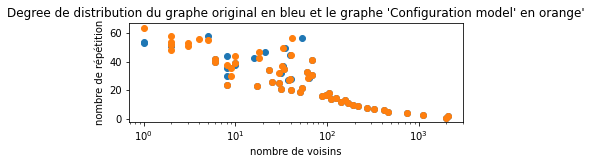

In [8]:
lists=sorted(G.items())
lists2=sorted(G1.items())
x,y=zip(*lists)
a,b=zip(*lists2)
plt.subplot(211)
plt.scatter(y,x)
plt.scatter(b,a)
plt.xscale("log")
plt.xlabel("nombre de voisins")
plt.ylabel("nombre de répétition")
plt.title("Degree de distribution du graphe original en bleu et le graphe 'Configuration model' en orange'")
plt.show()

In [10]:
#compariason du nombre de traingles
def adjList_to_adjMatrix(graph): #transformtion d'une liste adjacente à une matrice adjacente pour faciliter le calcul des triangles
    keys=sorted(graph.keys())
    size=len(keys)
    M = [ [0]*size for i in range(size) ]
    for a,b in [(keys.index(a), keys.index(b)) for a, row in graph.items() for b in row]:
           M[a][b] = 2 if (a==b) else 1
    return M
M1=adjList_to_adjMatrix(g2)

In [ ]:
#temps d'éxecution trop important
def countTriangle(adjMatrix): 
    nodes = len(adjMatrix) 
    count_Triangle = 0
    for i in range(nodes): 
        for j in range(nodes): 
            for k in range(nodes): 
                if( i!=j and i !=k and j !=k and 
                        adjMatrix[i][j] and adjMatrix[j][k] and adjMatrix[k][i]): 
                    count_Triangle += 1
    return int (count_Triangle/6)
print("le nombre de triangles dans le nouveau graphe est :", countTriangle(M1))

le nombre de triangles dans le nouveau graphe est : 96049

## Exercise 2: robustness analysis

### Question 3

In this question, we want to explore if the original network is more or less robust to attacks than the corresponding configuration model is. 

For this purpose, we follow the same protocol as the one we have seen in PW3: we plot the size of the LCC as a function of a number of nodes removed. Nodes are removed randomly.

Discuss your observations in one sentence, in particular do you think that the degree distribution alone can explain the robustness to random failures?

Oui d'après ce modèle de graphe aléatoire on déduit que le degré de distribution est un facteur important dans la robustesse du graphe

In [12]:
from datetime import datetime

def BFS(graph,s): 
    
    queue=[s]
    dist={}
    visited=[]

    dist[s]=0
   
    while queue:
        node=queue.pop(0)
        #visited.append(node)
        try:
            for neighbour in graph[node]:
                if neighbour not in visited:
                        visited.append(neighbour)
                        dist[neighbour]=dist[node]+1
                        queue.append(neighbour)
        except KeyError:
            continue
        
    return visited


def LargestConnectedComponent(graph):
    LCC=0
    v=[]
    for i in graph:
        while i not in v:
            BFS(g,i)
            for m in BFS(g,i):
                v.append(m)
            if len(BFS(g,i))>LCC:
                LCC=len(BFS(g,i))
    return LCC
start_time =datetime.now()
print(LargestConnectedComponent(g2)) 

end_time=datetime.now()
print('le temps d éxecution du programme est: {}'.format(end_time - start_time))

9431
le temps d éxecution du programme est: 0:00:17.432366


In [ ]:
def SuppressionNoeuds(graph,n):  
    for i in range(n):
        node = random.choice(list(graph.keys()))
        graph.pop(node)
        for j in graph.keys():
            if(node in graph[j]):
                graph[j].remove(node)
    lcc = LargestConnectedComponent(graph)
    return (n, lcc)

def getLCCperRandomDeleted(graph, x):
    node_list = len(graph.keys())
    liste = []
    for i in range(0, node_list, x):
        dict2 = graph.copy()
        liste.append(SuppressionNoeuds(dict2, i))
    return liste

G4= getLCCperRandomDeleted(g2, 1500)

liste1 = []
liste2 = []

for i in G4:
        liste1.append(i[0])
        liste2.append(i[1])
    
plt.plot(liste1)
plt.xlabel("nombre de noeud supprimés")
plt.ylabel("LCC")
plt.title("les noeuds supprimés")
plt.show()